# Merging raw data from crystal dataset
The aim of this script is to merge in a more confortable way the huge raw dataset available. In particular, for each crystal structure (we have 7 different crystal structure), the releated dataset will be loaded from a large-text-file. As output of this script we want a dataframe (X) which collect all the spectrum position (from 0 to 90, increasing by 0.02) and 7 different dataframe (one for each crystal structure), which collect the releated intensity with respect the X position in the spectrum. Moreover, in each Y dataset, we collect also the cell paramenters size, which will be used as target features in future task. Lastly, dataset will be saved.

## Import library

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import os

In [ ]:
import warnings 
warnings.filterwarnings('ignore')

## Select path name
User must enter the name of the path in which dataset is stored.

In [ ]:
path_name = input('Enter the path name for dataset: ')
path_name = '/content/' + path_name
dir_list = ''

if not os.path.exists(path_name):
    print('Error! Invalid path selected.')
else:
    print(path_name + ' is a valid path.')

    if not os.listdir(path_name):
      print("Warning! Empty directory.")
    else:
      dir_list = os.listdir(path_name)

Enter the path name for dataset: crystal-dataset
/content/crystal-dataset is a valid path.


In [ ]:
dir_list

['hexagonal_04.txt',
 'hexagonal_00.txt',
 'hexagonal_01.txt',
 'hexagonal_05.txt',
 'hexagonal_06.txt',
 'hexagonal_03.txt',
 'hexagonal_08.txt',
 'hexagonal_07.txt',
 'hexagonal_02.txt']

## Create dataframes to store the loaded dataset 
For each dataset, script will produce two different dataframe in output as followed:
*   ***x_coord_dataset***, which is a dataframe of size 1-by-4501  with information about the x-coord of the spectrum. In particular, we store point in the following interval [0,90] increasing by 0.02;
*   ***y_coord_dataset***, which is a datframe of size num_obs-by-4502 storing information about the recordered intensity, releated to each point stored in x-coord-dataset, with also id-observation





### Create dataframe to store the x-coordinates of the spectrum for each observation

In [ ]:
x_coord_dataset = pd.DataFrame(np.arange(0,90.02,0.02)).T
x_coord_dataset.columns = [f'x_{i}' for i in range(1,len(x_coord_dataset.T)+1)]   # Rename x_coord_dataset columns name
print('The x_coord_dataset has the following shape: ', x_coord_dataset.shape)     # Check the shape of x_coord_dataset
x_coord_dataset

The x_coord_dataset has the following shape:  (1, 4501)


,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_4492,x_4493,x_4494,x_4495,x_4496,x_4497,x_4498,x_4499,x_4500,x_4501
0,0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,...,89.82,89.84,89.86,89.88,89.9,89.92,89.94,89.96,89.98,90.0


### Create a dataframe to store the y-coordinates of the spectrum for each observation

In [ ]:
y_coord_dataset = pd.DataFrame(columns = [f'y_{i}' for i in range(1,4502)])
y_coord_dataset['ID_Observations'] = ''
y_coord_dataset

,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,...,y_4493,y_4494,y_4495,y_4496,y_4497,y_4498,y_4499,y_4500,y_4501,ID_Observations


### Create dataframe to store additional information 

In [ ]:
additional_information_dataset = pd.DataFrame(columns=['ID_Observations', 'a', 
                                                       'b', 'c', 'alpha', 'beta',
                                                       'gamma', 'Volume', 
                                                       'Crystal_Structure_Type'])
additional_information_dataset

,ID_Observations,a,b,c,alpha,beta,gamma,Volume,Crystal_Structure_Type


## Loading the dataset using chunk

In [ ]:
chunksize = 150
k = 1
for file in dir_list:
  print('============================================================================')
  print('WORKING ON FILE NUMBER: {:d}'.format(k))

  i = 1

  with pd.read_csv(path_name + '/' + file, sep='|', header=None, index_col = None, 
                  names=["Spectrum_Data", "Cell_Parameters", "Volume", 
                          "ID_Observations", "Crystal_Structure_Type"], 
                  chunksize=chunksize, usecols = [0,1,2,3,4]) as reader:
                  for chunk in reader:
                    print('----------------------------------------------------------------------------')
                    print('Working of chunk number: {:d}'.format(i))
                    print('----------------------------------------------------------------------------')
                    print("DataType: {} \nShape: {} \nMemory: {}".format(type(chunk),
                                                chunk.shape, 
                                                chunk.memory_usage().sum()))
                    
                    # Retrive field for additional_information_dataset dataframe
                    chunk[['a', 'b', 'c', 'alpha', 'beta', 'gamma',]] = chunk.Cell_Parameters.str.split(' ', expand=True)
                    chunk.pop('Cell_Parameters')
                    additional_information_single_chunk = chunk[['ID_Observations', 
                                                                  'a', 'b', 'c', 
                                                                  'alpha', 'beta',
                                                                  'gamma', 'Volume',
                                                                  'Crystal_Structure_Type']]
                    additional_information_dataset = pd.concat([additional_information_dataset, 
                                                                additional_information_single_chunk], ignore_index= True)
                    
                    # Retrive and split specrtum field
                    xy_chunk = chunk['Spectrum_Data'].str.split(' ', expand=True)
                    x_y_chunk = pd.DataFrame()

                    j = 1
                    for col in xy_chunk.columns:
                      x_y_chunk[[f'x_{j}', f'y_{j}']] = xy_chunk[col].str.split(';', expand = True)
                      j = j + 1

                    # Drop column with name starting with 'x_'
                    x_y_chunk = x_y_chunk.loc[:, ~x_y_chunk.columns.str.contains('^x_')]
                                        
                    x_y_chunk['ID_Observations'] = chunk.ID_Observations

                    y_coord_dataset = pd.concat([y_coord_dataset, x_y_chunk], ignore_index= True)
                    
                    i = i + 1
  k = k + 1

WORKING ON FILE NUMBER: 1
----------------------------------------------------------------------------
Working of chunk number: 1
----------------------------------------------------------------------------
DataType: <class 'pandas.core.frame.DataFrame'> 
Shape: (150, 5) 
Memory: 6128
----------------------------------------------------------------------------
Working of chunk number: 2
----------------------------------------------------------------------------
DataType: <class 'pandas.core.frame.DataFrame'> 
Shape: (150, 5) 
Memory: 6132
WORKING ON FILE NUMBER: 2
----------------------------------------------------------------------------
Working of chunk number: 1
----------------------------------------------------------------------------
DataType: <class 'pandas.core.frame.DataFrame'> 
Shape: (150, 5) 
Memory: 6128
----------------------------------------------------------------------------
Working of chunk number: 2
----------------------------------------------------------------

In [ ]:
print('x_coord_dataset shape: {}'.format(x_coord_dataset.shape))
print('x_coord_dataset data types: \n{}'.format(x_coord_dataset.dtypes))

x_coord_dataset shape: (1, 4501)
x_coord_dataset data types: 
x_1       float64
x_2       float64
x_3       float64
x_4       float64
x_5       float64
           ...   
x_4497    float64
x_4498    float64
x_4499    float64
x_4500    float64
x_4501    float64
Length: 4501, dtype: object


In [ ]:
print('y_coord_dataset shape: {}'.format(y_coord_dataset.shape))
print('y_coord_dataset data types: \n{}'.format(y_coord_dataset.dtypes))

y_coord_dataset shape: (2543, 4502)
y_coord_dataset data types: 
y_1                object
y_2                object
y_3                object
y_4                object
y_5                object
                    ...  
y_4498             object
y_4499             object
y_4500             object
y_4501             object
ID_Observations    object
Length: 4502, dtype: object


In [ ]:
print('additional_information_dataset shape: {}'.format(additional_information_dataset.shape))
print('additional_information_dataset data types: \n{}'.format(additional_information_dataset.dtypes))

additional_information_dataset shape: (2543, 9)
additional_information_dataset data types: 
ID_Observations            object
a                          object
b                          object
c                          object
alpha                      object
beta                       object
gamma                      object
Volume                    float64
Crystal_Structure_Type     object
dtype: object


## Basic checks

### Casting of numeric field from *object* to *float*

In [ ]:
index_name = y_coord_dataset.select_dtypes(include='object').columns
index_name = index_name.drop('ID_Observations')
y_coord_dataset[index_name] = y_coord_dataset[index_name].astype("float")
print('y_coord_dataset data types after casting operation: \n{}'.format(y_coord_dataset.dtypes))

y_coord_dataset data types after casting operation: 
y_1                float64
y_2                float64
y_3                float64
y_4                float64
y_5                float64
                    ...   
y_4498             float64
y_4499             float64
y_4500             float64
y_4501             float64
ID_Observations     object
Length: 4502, dtype: object


In [ ]:
index_name = additional_information_dataset.select_dtypes(include='object').columns
index_name = index_name.drop('Crystal_Structure_Type')
index_name = index_name.drop('ID_Observations')
additional_information_dataset[index_name] = additional_information_dataset[index_name].astype("float")
print('additional_information_dataset data types after casting operation: \n{}'.format(additional_information_dataset.dtypes))

additional_information_dataset data types after casting operation: 
ID_Observations            object
a                         float64
b                         float64
c                         float64
alpha                     float64
beta                      float64
gamma                     float64
Volume                    float64
Crystal_Structure_Type     object
dtype: object


### Merging additional_information_dataset and y_coord_dataset on ID_Observations

In [ ]:
y_coord_dataset = y_coord_dataset.merge(additional_information_dataset, on = 'ID_Observations')
print('y_coord_dataset shape: {}'.format(y_coord_dataset.shape))
print('y_coord_dataset data types: \n{}'.format(y_coord_dataset.dtypes))

y_coord_dataset shape: (2543, 4510)
y_coord_dataset data types: 
y_1                       float64
y_2                       float64
y_3                       float64
y_4                       float64
y_5                       float64
                           ...   
alpha                     float64
beta                      float64
gamma                     float64
Volume                    float64
Crystal_Structure_Type     object
Length: 4510, dtype: object


### Check for *null* field

Null field in y_coord_dataset: 
y_1                       False
y_2                       False
y_3                       False
y_4                       False
y_5                       False
                          ...  
alpha                     False
beta                      False
gamma                     False
Volume                    False
Crystal_Structure_Type    False
Length: 4510, dtype: bool


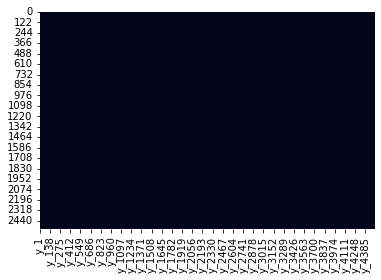

In [ ]:
print('Null field in y_coord_dataset: \n{}'.format(y_coord_dataset.isnull().any()))
sns.heatmap(y_coord_dataset.isnull(), cbar=False)

### Check for NaN rows and drop it

In [ ]:
n_samples = y_coord_dataset.shape[0]
y_coord_dataset = y_coord_dataset.dropna()   
print('Number of NaN rows dropped: {}/{} ({:.2f}%)'.format(n_samples - y_coord_dataset.shape[0], n_samples, (n_samples - y_coord_dataset.shape[0]) / n_samples * 100))

Number of NaN rows dropped: 0/2543 (0.00%)


### Check for duplicate rows and drop, if exists

In [ ]:
duplicated_rows = y_coord_dataset[y_coord_dataset.duplicated()]
n_samples = y_coord_dataset.shape[0]  
duplicates = n_samples - y_coord_dataset.shape[0]

if not duplicated_rows.empty:
  y_coord_dataset.drop_duplicates(ignore_index=True, inplace=True)
  print('Number of canceled duplicates: {}/{} ({:.2f}%)'.format(duplicates, n_samples, duplicates / n_samples * 100))
else:
  print('Number of canceled duplicates: {}/{} ({:.2f}%)'.format(duplicates, n_samples, duplicates / n_samples * 100))

Number of canceled duplicates: 0/2543 (0.00%)


## Show dataset content

In [ ]:
print('x_coord_dataset content: ')
x_coord_dataset

x_coord_dataset content: 


,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,...,x_4492,x_4493,x_4494,x_4495,x_4496,x_4497,x_4498,x_4499,x_4500,x_4501
0,0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,...,89.82,89.84,89.86,89.88,89.9,89.92,89.94,89.96,89.98,90.0


In [ ]:
print('y_coord_dataset content: ')
y_coord_dataset

y_coord_dataset content: 


,y_1,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,y_10,...,y_4501,ID_Observations,a,b,c,alpha,beta,gamma,Volume,Crystal_Structure_Type
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219,4125976,16.6590,16.6590,32.2170,90.0,90.0,120.0,7743.076,Hexagonal
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.451,4125977,16.2897,16.2897,32.2513,90.0,90.0,120.0,7411.462,Hexagonal
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.088,4126014,20.4847,20.4847,6.8358,90.0,90.0,120.0,2484.157,Hexagonal
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002,4126185,25.9453,25.9453,19.5015,90.0,90.0,120.0,11368.835,Hexagonal
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.069,4126206,19.4252,19.4252,12.1355,90.0,90.0,120.0,3965.694,Hexagonal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001,4001880,9.5935,9.5935,13.8360,90.0,90.0,120.0,1102.796,Hexagonal
2539,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.593,4001881,5.8797,5.8797,13.7200,90.0,90.0,120.0,410.766,Hexagonal
2540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.014,4001882,5.8841,5.8841,13.7950,90.0,90.0,120.0,413.630,Hexagonal
2541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000,4001998,6.1264,6.1264,5.6914,90.0,90.0,120.0,184.995,Hexagonal


## Saving the new dataset

In [ ]:
def save_dataset(dataset):
  save_data = input('Do you want to save x_coord_dataset [y|n]: ')
  if save_data.lower() == 'y':
    path_dataset = input('Enter path in which to store dataset: ')
    name_dataset = input('Enter dataset name you want to save: ')
    valid_dataset_path = '/content/' + path_dataset

    if os.path.exists(valid_dataset_path):
      complete_path = valid_dataset_path + '/' + name_dataset + '.csv'
      dataset.to_csv(complete_path, sep=';', index=False, header=True)
      print('Dataset stored in : ',complete_path)
    else:
      print('Error! Invalid name of dataset or Not uploaded dataset has been requested.\n'
            +'Please, enter a valid dataset name to continue.')
  elif save_data.lower() == 'n':
    print('Dataset will NOT be saved!')

### Saving x_coord_dataset

In [ ]:
save_dataset(x_coord_dataset)

Do you want to save x_coord_dataset [y|n]: n
Dataset will NOT be saved!


### Saving y_coord_dataset

In [ ]:
save_dataset(y_coord_dataset)

Do you want to save x_coord_dataset [y|n]: y
Enter path in which to store dataset: crystal-splitted-dataset
Enter dataset name you want to save: y_coord_dataset_hexagonal
Dataset stored in :  /content/crystal-splitted-dataset/y_coord_dataset_hexagonal.csv
